# STA-663 Final Project: An Implementation of Regularized Linear Regression through Lasso and Elastic Net, with code optimization by different methods

by Luis Guirola, Xiaodong Zhai

## I. Introduction

### Why elastic net?

Regularized regression has now become one of the major tools of supervised learning for data analysis. Although its intellectual origins go as far as to the James-Stein estimator (1961) [1] and have an inmediate antecedent in the Tikhonov regularization (Ridge regression), a recent monograph reports how [[2]](http://web.stanford.edu/~hastie/StatLearnSparsity/index.html), since Tibshirani's original contribution (1996) [[3]](http://statweb.stanford.edu/~tibs/lasso/lasso.pdf) this field has been a vibrant one for the last twenty years. 

A key factor behind this prominence is the ruthless pragmatism of regularization methods. Traditional statistics and econometrics, in particular those of a frequentist flavor, evaluated estimator according to desirable asymptotic properties whose relevance held only under specific assumptions. In contrast, by balancing bias and variance and limiting overfitting, regularization is specifically designed for prediction purposes whose output can be fed into actual decision problems.

A particular advantage of LASSO and its successors (of which elastic net is a prominent example) is that it performs variable selection, according to its predictive power. LASSO appears as a convenient method to find relations between variables. This is of particular importance at least in two respects. When dealing with sparse data, standard OLS regression is not operative since the system is overdetermined. Moreover, when the functional form of the relation is not known, and cannot be approached succesfully by a linear model, it allows to fit more complex functional forms which otherwise may make the parameter space grow exponentially.

In this project we approach the implementation of Elastic net using a coordinate descent algorithm. Elastic net is a technique originally proposed in by Zou Hastie (2005) which combines the penalty of the LASSO (absolute value) with that of ridge regression (quadratic). Following [[Friedman et al 2007 , pg 6]](http://arxiv.org/pdf/0708.1485.pdf), it the solution solves the following problem:

$$min_{\beta} \frac{1}{2} \sum (y_i -\sum x_{ij} \beta_j)^2 + \lambda \sum_{j} (\alpha |\beta_j| + (1-\alpha) \frac{\beta_{j}^2}{2})$$

As it can be seen, the system is a modified OLS, in which a conver combination of a quadratic and an absolute value penalty is imposed on the coefficients. 

Our choice of the Elastic Net method is guided by its generality and flexibility. As it can be seen, for extreme values of $\alpha \in [0,1]$, the problem collapses in a LASSO or Ridge regression minimization. Alternatively, for a parametrization of $\lambda = 0$, the system provides an OLS solution. We chose to emulate this versatility from the package _[glmnet](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html)_ by Hatie and Qian. 

Elastic net is also more flexible than its alternatives. At the cost of incorporate an additional parameter, it accomodates convex combinations of the LASSO and Ridge penalty.  A problem recognized in LASSO concerns that it tends to over-shrink those variables that have a small but still non-null effect, as well as those that are highly correlated.  This problem is compounded by that of the non-uniqueness of the solution [5](http://arxiv.org/abs/1206.0313): in the presence of highly correlated or quasi-colinear predictors, both may overlap in their predictive power and the algorithm may choose either of them, depending on the starting point. An alternative to fix this problem is the group lasso [6], which selects groups of coefficients that naturally should be considered as going together. Elastic net attenuates this problem by combining the ridge and lasso penalties as a mid point.

### coordinate descent

The original Zou Hastie [4] paper proposed an homotophy method, LARS-EN, based on the original algorithm proposed by Efron et all (2004) [[7]](http://statweb.stanford.edu/~tibs/ftp/lars.pdf). Currently, however, a particularly efficient algorithm for computing the solution is the so called, _coordinate descent method_. If the data are standardized so that $ \frac{\sum x_i^2}{n} =1 $ and $\sum x_i=0$, the algorithm can be defined as:

$$ \beta_j \leftarrow \frac{S(\frac{\sum_i x_{ij} (y_i - \hat{y_i^j})_{+}}{n} , \lambda \alpha )}{1+(\lambda(1-\alpha) )} $$

Where the soft threshold operator is given by

$$S(\beta, \tau) = sign(\beta) (|\beta|-\tau)$$

And $\hat{y_i^j} = \sum_{k \neq j } x_{ik} \beta_{k}$ stands for the fitted values of the standing betas ignoring the jth column.

The algorithm cycles through the vector of coefficients updating them one at a time through simple OLS. It then applies a correction for the penalization factors. The soft threshold operator allows to solve the problem that the objective function is not differentiable in the neighborhood of zero. Interestingly, thus, the algorithms simplifies dramatically the optimization problem and makes it computationally tractable. From the functional form, the algorithm is guaranteed to converged to a global minimum. 




## II. Implementation

### coordinate descnet

The coordinate descent algorithm can be implemented using the basic Python packages of numpy and pandasfor linear algebra and data manipulation. We will also make use of sklearn for auxiliary data pre-processing. 

We will start coding the **soft-threshold operator**.

$$S(\beta, \tau) = sign(\beta) (|\beta|-\tau)$$

And $\hat{y_i^j} = \sum_{k \neq j } x_{ik} \beta_{k}$ stands for the fitted values of the standing betas ignoring the jth column.

### import neccessary packages

In [5]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
import statsmodels as sm
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize, scale

### soft-threshold operator

In [9]:
def S(z, gamma):
    '''
    Input: 
    - coeficient: z
    - gamma: a regularization factor
    '''
    if np.abs(z) - gamma > 0:
        return np.sign(z)*(np.abs(z) - gamma)
    else:
        return 0

We now proceed to implement the algorithm. The function has three parts:
    
   1. **Data preprocessing:** the coordinate descent algortihm works adequately when the data is normalized. We perform this using the `sklearn` package.
   2. **Initialization**: 
   3. **Two nested loops** an inner loop that updates sequentially over the vector of coefficients using the rule described above, and an outer loop that controls the number of cycles implemented.


### A Python Implementation

In [ ]:
def coordinate_descent(data_X, data_y, b0 , maxiter = 200000, tol = 0.00001, alpha = .5, l1_ratio = 1):
    '''
    INPUT
    -data_X: array-like
            array of exogenous variables
    -data_y: array-like
            array (vector) of endogenous variables
    -b0: array-like
        initial guess of beta
    -alpha: saclar
            penalization/shrinking parameters
    -l1_ratio: scalar
            weight put on the lasso, 1-l1_ratio is the weight put on the ridge
    -maxiter: scalar, int
            maximum number of iterations
    -tol: scalar,
            level of tolerance for convergence.
    
    OUTPUT
    -path: path of optimization
    -b: optimal coefficients
    -Note: output is for standardized coeficients
    '''
    #1.Standardize the data#
    ########################
    X = scale(data_X, axis=0); y = scale(data_y)
    
    #2.Initialize#
    ##############
    b = b0
    p = X.shape[1];N = X.shape[0]
    b_new = b + np.ones(p)*3000
    path = []; path.append(b.copy())

    #3.Start outer loop#
    ####################
    for itr in range(maxiter):
        #3.1. Check convergence#
        if np.linalg.norm(b_new-b)/np.linalg.norm(b) <tol:           
            #Plot the path
            path.append(b_new.copy())
            plt.plot(path[:10])
            #Print message:
            print('Convergence achieved after', itr, 'iterations')
            #Return the path and the coefficients
            return  b_new   
        
        #3.2 If not convergece, take another internal loop
        else:
            b = b_new.copy()
            path.append(b.copy())
            #Loop accross coordinates
            for j in range(p):
                b_new[j] = S(1/N * np.dot(X[:,j], (y - (np.dot(X,b) - np.dot(X[:,j], b_new[j]))))
                             , alpha*l1_ratio)/(1+alpha*(1-l1_ratio)) 
    #If convergence is not achieve:
    print('Maximum iterations', itr,'exhausted, coefficents \n',b)

Note that in the above code we record all the updates made at each iteration in order to be able to plot the convergence of the algorithm. 

### Demonstration with  Data

In order to demonstrate the working of the function we generate some data and try it. 

#### randomly generating data

In [11]:
np.random.seed(42)

pp = 100 # control of num_features
n = 100000 # control of num_samples
n_samples, n_features =n , pp
data_X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
# sparsify coef
coef[inds[5:]] = 0  
data_y = np.dot(data_X, coef)
# add noise
data_y += 0.02 * np.random.normal((n_samples,))

#### run naive python code

Convergence achieved after 5 iterations


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

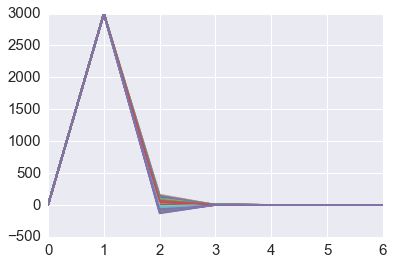

In [5]:
coordinate_descent(data_X, data_y, b0 = np.zeros(data_X.shape[1]), 
                   maxiter = 200000, tol = .1, alpha = 1, l1_ratio = .5)

As can be seen, the algorithm jumps in the first two iteration and then steadily converges in a few iterations more.

#### Test comparing with sklearn results

We compare our results with those obtained and find that they are identical. 

In [16]:
from sklearn.linear_model import ElasticNet
#Standardize first the data
data_X =scale(data_X, axis = 0)
data_y = scale(data_y)

#Run sklearn
enet = ElasticNet(alpha=1, l1_ratio=0.5).fit(data_X,data_y).coef_
enet

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

## III. Performance and Optimization

We turn to consider the performance of our implementation. 

To do this, we use magic `%time` available in Jupyter Notebook.

The purely naive Python code is too slow to get results within 1 minute. We first look at how the simple implementation works

Convergence achieved after 5 iterations
CPU times: user 13.6 s, sys: 6.15 s, total: 19.7 s
Wall time: 2.71 s


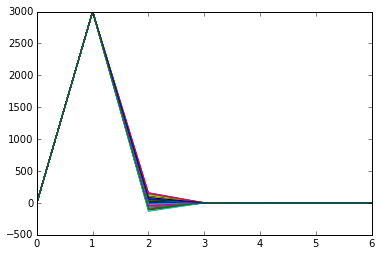

In [37]:
%%time
coordinate_descent(data_X, data_y, b0 = np.zeros(data_X.shape[1]), 
                   maxiter = 200000, tol = .1, alpha = 1, l1_ratio = .5)

pass

### Optimization: Numba JIT

In [17]:
import numba
from numba import jit

In [24]:
@jit()
def numba_coordinate_descent(data_X, data_y, b0 , maxiter=200000, tol=0.00001, alpha =.5, l1_ratio=1):
    '''
    INPUT
    -data_X: array-like
            array of exogenous variables
    -data_y: array-like
            array (vector) of endogenous variables
    -b0: array-like
        initial guess of beta
    -alpha: saclar
            penalization/shrinking parameters
    -l1_ratio: scalar
            weight put on the lasso, 1-l1_ratio is the weight put on the ridge
    -maxiter: scalar, int
            maximum number of iterations
    -tol: scalar,
            level of tolerance for convergence.
    
    OUTPUT
    -path: path of optimization
    -b: optimal coefficients
    -Note: output is for standardized coeficients
    '''
    #1.Standardize the data#
    ########################
    X = scale(data_X, axis=0)
    y = scale(data_y)
    
    #2.Initialize#
    ##############
    b = b0
    p = X.shape[1];N = X.shape[0]
    b_new = b + np.ones(p)*3000
    path = []; path.append(b.copy())

    #3.Start outer loop#
    ####################
    for itr in range(maxiter):
        #3.1. Check convergence#
        if np.linalg.norm(b_new-b)/np.linalg.norm(b) <tol:           
            #Plot the path
            path.append(b_new.copy())
            plt.plot(path[:10])
            #Print message:
            print('Convergence achieved after', itr, 'iterations')
            #Return the path and the coefficients
            return  b_new   
        
        #3.2 If not convergece, take another internal loop
        else:
            b = b_new.copy()
            path.append(b.copy())
            #Loop accross coordinates
            for j in range(p):
                b_new[j] = S(1/N * np.dot(X[:,j], (y - (np.dot(X,b) - np.dot(X[:,j], b_new[j]))))
                             , alpha*l1_ratio)/(1+alpha*(1-l1_ratio)) 
    #If convergence is not achieve:
    print('Maximum iterations', itr,'exhausted, coefficents \n',b)

Convergence achieved after 5 iterations
CPU times: user 16 s, sys: 7.19 s, total: 23.2 s
Wall time: 4.42 s


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

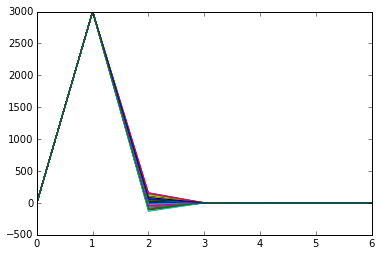

In [25]:
%%time
numba_coordinate_descent(data_X, data_y, b0=np.zeros(data_X.shape[1]), 
                         maxiter=200000, tol=0.1, alpha=1, l1_ratio=.5)

Interestingly, the numba compilation does not improve upon the original implementation. The reason for this is that most of what is computationally expensive in the algorithm -the inner products that have to be calculated at each step- is implemented using the numpy which is already optimized. 

In order to compare the mechanics of optimization we will proceed to compare:
    1. Naive python implementation using loops to calculate inner products and avoiding the use of numpy
    2. Numpy optimized version  -like the above.
    3. Python paralellized
    4. C++ wrapped with python.

We attempted to compare it with a cython anotated version, but we did not have time to debug it properly. This material is included in the appendix.

### Naive Python without numpy

Below are a series of functions that implement the naive python with loops.

In [38]:
def estimated_y_i(x, N, p, beta, i):
    '''
    Parameters
        x: data vector
        N: num_samples
        p: num_features
        beta: beta
        i: corresponding index
    Returns
        s: estimated y[i]
    '''
    s = 0
    for j in range(p):
        s += x[i, j] * beta[j]
    return s

def compute_intermediate_b(x, m, n, y, beta, j):
    '''
    Parameters
        x: data vecotr
        m: num_samples
        n: num_features
        y: data vector
        beat: beta vector
        j: input j (of n features)
    Returns
        res: innerproduct of x and residual
    '''
    res = 0
    for i in range(m):
        res += x[i, j] * (y[i] - estimated_y_i(x, m, n, beta, i))
    return res

def sign(x):
    '''
    Parameters
        x: data
    returns
        sign of x
    '''
    if x >= 0: 
        return 1
    else:
        return -1

def S(z, gamma):
    '''
    return soft-threshold result
    '''
    if abs(z) - gamma > 0:
        return sign(z) * (abs(z) - gamma)
    else:
        return 0
    
def coord_desc(x, y, num_samples, num_features, beta_0, 
               alpha=1.0, L1_ratio=0.5, max_iter=1000, tol=1e-7):
    '''
    INPUT
    -x: array-like
            array of exogenous variables
    -y: array-like
            array (vector) of endogenous variables
    -beta_0: array-like
        initial guess of beta
    -num_samples:
        number of samples
    -num_features:
        number of features
    -alpha: saclar
            penalization/shrinking parameters
    -l1_ratio: scalar
            weight put on the lasso, 1-l1_ratio is the weight put on the ridge
    -maxiter: scalar, int
            maximum number of iterations
    -tol: scalar,
            level of tolerance for convergence.
    
    OUTPUT
    -path: path of optimization
    -b: optimal coefficients
    -Note: output is for standardized coeficients
    '''
    N, p = num_samples, num_features
    bb = 0
    beta_new = np.zeros(p)
    b = beta_0.copy()
    
    for itr in range(max_iter):
        for j in range(p):
            bb = S(b[j] + compute_intermediate_b(x, N, p, y, b, j) / N,
                  alpha*L1_ratio) / (1. + alpha*(1-L1_ratio))
        
            beta_new[j] = bb
        
        b = beta_new.copy()
        
    if np.linalg.norm(beta_new - b, 2) > tol:
        print('not converge')
    else:
        print('converged')
        
    return b

def nv_py_regular_linreg(X, y, beta_0, alpha, L1_ratio, max_iter=1000, tol=0.0001):
    '''
    Takes regressors X and variables y, two regulazation parameters (L1_ratio and alpha) and 
    a vector of initial parameters as input, and returns the elastic net implementation
    '''
    num_samples, num_features = X.shape
    res = coord_desc(X, y, num_samples, num_features, beta_0,
              alpha, L1_ratio, max_iter=1000, tol=1e-7)
    return res

We also looked at the **jit -numba** compiled version of this system. 

In [52]:
import numba
from numba import jit

@jit()
def numba_estimated_y_i(x, N, p, beta, i):
    s = 0
    for j in range(p):
        s += x[i, j] * beta[j]
    return s

@jit()
def numba_compute_intermediate_b(x, m, n, y, beta, j):
    res = 0
    for i in range(m):
        res += x[i, j] * (y[i] - numba_estimated_y_i(x, m, n, beta, i))
    return res


@jit()    
def coord_desc(x, y, num_samples, num_features, beta_0, 
               alpha=1.0, L1_ratio=0.5, max_iter=1000, tol=1e-7):
    N, p = num_samples, num_features
    bb = 0
    beta_new = np.zeros(p)
    b = beta_0.copy()
    
    for itr in range(max_iter):
        for j in range(p):
            bb = S(b[j] + numba_compute_intermediate_b(x, N, p, y, b, j) / N,
                  alpha*L1_ratio) / (1. + alpha*(1-L1_ratio))
        
            beta_new[j] = bb
        
        b = beta_new.copy()
        
    if np.linalg.norm(beta_new - b, 2) > tol:
        print('not converge')
    else:
        print('converged')
        
    return b

@jit()
def numba_nv_py_regular_linreg(X, y, beta_0, alpha, L1_ratio, max_iter=1000, tol=0.0001):
    '''
    Takes regressors X and variables y, two regulazation parameters (L1_ratio and alpha) and a vector of initial parameters as input, and returns the elastic net implementation
    '''
    num_samples, num_features = X.shape
    res = coord_desc(X, y, num_samples, num_features, beta_0,
              alpha, L1_ratio, max_iter=1000, tol=1e-7)
    return res

### Optimization: Numpy as well as Vectorization

This is a simplified version of our implementation above to make it fully comparable. 

In [53]:
def np_py_regular_linreg(X, y, beta_0, alpha, L1_ratio, max_iter=1000, tol=0.0001):
    '''
    INPUT
    -x: array-like
            array of exogenous variables
    -y: array-like
            array (vector) of endogenous variables
    -beta_0: array-like
        initial guess of beta
    -num_samples:
        number of samples
    -num_features:
        number of features
    -alpha: saclar
            penalization/shrinking parameters
    -l1_ratio: scalar
            weight put on the lasso, 1-l1_ratio is the weight put on the ridge
    -maxiter: scalar, int
            maximum number of iterations
    -tol: scalar,
            level of tolerance for convergence.
    
    OUTPUT
    -path: path of optimization
    -b: optimal coefficients
    -Note: output is for standardized coeficients
    '''
    def S(z, gamma):
        if np.abs(z) - gamma > 0:
            return np.sign(z)*(np.abs(z)-gamma)
        else:
            return 0
    N, p = X.shape
    beta = beta_0.copy()
    b_new = np.zeros(p)
    for itr in range(max_iter):
        for j in range(p):
            b_new[j] = S(1/N * np.dot(X[:,j], (y - (np.dot(X,beta) - np.dot(X[:,j], beta[j]))))
                     , alpha*L1_ratio)/(1+alpha*(1-L1_ratio))
        beta = b_new
    return beta

### Optimization: ProcessPoolExecutor - Multi-Processing

We test the paralellization using ProcessPoolExecutor from `concurrent.futures`

__However__, we do not recommend to use multi-processing tech here. The reason is that within the coordinate descent scope, there is not much thing to parallelize. This is due to the fact that in an iteration algorithm, the result at kth iteration needs what is produced in the previous iteration and thus no parallelization is needed (or even can not be added).

Of course, the independence of n features within the coordinate descent scope is where we can utilize parallel computing. But given the truth that it consumes computer's resources to do multi-processing, we can not guarantee that using multiprocessing in 1000 iterations would be more efficient. 

But we did our work and multi-processing is actually working here. Though not perfectly accelarating.

In [54]:
def deco(j, X, y, N, p, beta, alpha, L1_ratio):
    '''
    decorator function to facilitate multi-processing computing
    '''
    
    def S(z, gamma):
        if np.abs(z) - gamma > 0:
            return np.sign(z)*(np.abs(z)-gamma)
        else:
            return 0
        
    return S(1./N*np.dot(X[:,j], (y - (np.dot(X,beta) - np.dot(X[:,j], beta[j]))))
                     , alpha*L1_ratio)/(1+alpha*(1-L1_ratio))


def mp_py_regular_linreg(X, y, beta_0, alpha, L1_ratio, max_iter=50, tol=0.0001):
    from itertools import repeat
    from concurrent.futures import ProcessPoolExecutor
    
    N, p = X.shape
    beta = beta_0.copy()
    b_new = np.zeros(p)
    
    for itr in range(max_iter):
        with ProcessPoolExecutor(max_workers=8) as pool:
            b_new = np.array(list(pool.map(deco, [j for j in range(p)], repeat(X), repeat(y), repeat(N),
                                           repeat(p), repeat(beta), repeat(alpha), repeat(L1_ratio))))
        beta = b_new
    return beta  

### Optimization: C++ wrapped up by Cython

Cython offers the possibility to interact with c++ from Python. 

We use this facility here. 

#### wrting .hpp, .cpp, .pxd, .pyx files and config setup.py

In [55]:
%%file cpp_regularized_linreg.hpp
double estimated_y_i(double *x, int N, int p, double *beta, int i);
double compute_intermediate_b(double *x, int m, int n, double *y, double *beta, int j);
double S(double z, double gamma);    
double* coord_desc(double *x, double *y, int num_samples, int num_features, double *beta, 
                   double alpha, double L1_ratio, int max_iter, double tol);

Overwriting cpp_regularized_linreg.hpp


In [56]:
%%file cpp_regularized_linreg.cpp
#include <iostream>

using namespace std;

double estimated_y_i(double *x, int N, int p, double *beta, int i) {
	double s = 0;
	int l;
	for(l = 0; l < p; l++) {
		s += x[i*p + l] * beta[l];
	}
	return s;
}


double compute_intermediate_b(double *x, int m, int n, double *y, double *beta, int j) {
	double res = 0;
	int i;
	
	for(i = 0; i < m; i++) {
		res += x[i*n + j] * (y[i] - estimated_y_i(x, m, n, beta, i));
	}
	return res;
}

double S(double z, double gamma) {
	if(z >= 0) {
		if (z - gamma > 0) {
			return z - gamma;
		}
		else {
			return 0;
		}
	}
	else {
		if (-z - gamma > 0) {
			return z + gamma;
		}
		else {
			return 0;
		}
	}
}


double* coord_desc(double *x, double *y, int num_samples, int num_features, double *beta, 
                   double alpha, double L1_ratio, int max_iter=1000, double tol=0.0001) {
    
	int itr, j, i, 
    N = num_samples, 
    p = num_features;
    
	double bb;
    double b[p];
    
    double beta_new[p];
    
    double res;
    
    for(j = 0; j < p; j++){
        b[j] = beta[j];
    }
    
	for(itr = 0; itr < max_iter; itr++) {
		for(j = 0; j < p; j++) {
		       bb = S(b[j] + compute_intermediate_b(x, N, p, y, b, j) / N, alpha*L1_ratio) / (1. + alpha * (1 - L1_ratio));
		       beta_new[j] = bb;
		}
        
        for(j = 0; j < p; j++){
            b[j] = beta_new[j];
        } 
  
	}
    
    
    
    
    for(j = 0; j < p; j++){
            beta[j] = b[j];
        }
    
	return beta;
}




Overwriting cpp_regularized_linreg.cpp


In [57]:
%%file cy_regularized_linreg.pxd

cdef extern from "cpp_regularized_linreg.hpp":
    double* coord_desc(double *x, double *y, int num_samples, int num_features, double *beta, 
                       double alpha, double L1_ratio, int max_iter, double tol)

Overwriting cy_regularized_linreg.pxd


In [58]:
%%file cy_regularized_linreg.pyx
# distutils: language = c++
# distutils: sources = cpp_regularized_linreg.cpp

cimport cy_regularized_linreg

def py_regularized_linreg(double[::1] data_x, double[::1] data_y, int num_samples, int num_features, 
                          double[::1] beta, double alpha, double L1_ratio, int max_iter, double tol):
    
    cy_regularized_linreg.coord_desc(&data_x[0], &data_y[0], num_samples, num_features, 
                                                 &beta[0], alpha, L1_ratio, max_iter, tol)

Overwriting cy_regularized_linreg.pyx


In [46]:
%%file setup.py

from distutils.core import setup, Extension
from Cython.Build import cythonize
import numpy as np

ext = Extension("cy_regularized_linreg",
                sources=["cy_regularized_linreg.pyx","cpp_regularized_linreg.cpp"],
                libraries=["m"],
                language=["c++"],
                extra_compile_args=["-std=c++11","-static"])

setup(name = "cy_regul_linreg",
      ext_modules = cythonize(ext))

Writing setup.py


#### Compile the code


In [47]:
! python setup.py clean
! python setup.py -q build_ext --inplace
pass

Compiling cy_regularized_linreg.pyx because it changed.
Cythonizing cy_regularized_linreg.pyx
running clean
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++ [enabled by default]
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++ [enabled by default]
cpp_regularized_linreg.cpp: In function 'double* coord_desc(double*, double*, int, int, double*, double, double, int, double)':
cpp_regularized_linreg.cpp:48:14: warning: unused variable 'i' [-Wunused-variable]
  int itr, j, i, 
              ^
cpp_regularized_linreg.cpp:57:12: warning: unused variable 'res' [-Wunused-variable]
     double res;
            ^


## IV. Experimental Results: Comparison of Optimization Strategies Above

Start generating some data to be able to perform the comparisons. We use for this matter the diabetes dataset from the scikit learn package. 

In [50]:
from sklearn import datasets
from sklearn.preprocessing import scale
ds = datasets.load_diabetes()
data_X = ds.data
data_y = ds.target
num_samples, num_features = data_X.shape
print(data_X.shape, data_y.shape)

## standardize data
X, y = scale(data_X, axis=0), scale(data_y)

(442, 10) (442,)


### benchmark
We now time a benchmark for the naive implementation and then compare it to the other implementations.

In [59]:
import time
start = time.time()
nv_py_regular_linreg(X, y, np.zeros(num_features), alpha=0.5, L1_ratio=1)
naive_time = time.time() -start

converged


In [60]:
start = time.time()
numba_nv_py_regular_linreg(X, y, np.zeros(num_features), alpha=0.5, L1_ratio=1)
numba_naive_time = time.time() -start

converged


In [61]:
start = time.time()
np_py_regular_linreg(X, y, np.zeros(num_features), alpha=0.5, L1_ratio=1)
numpy_time = time.time() -start

In [62]:
start = time.time()
mp_py_regular_linreg(X, y, np.zeros(num_features), alpha=0.5, L1_ratio=1)
mp_py_time = time.time() -start

In [63]:
import cy_regularized_linreg
start = time.time()
cy_regularized_linreg.py_regularized_linreg(X.reshape((np.prod(X.shape),)), y, \
                                            num_samples, num_features, np.zeros(num_features), 1, 0.5, 1000, 0.001)
cpp_time = time.time() -start

### Comparison

In [64]:
print('Speed Up Improvement numba',naive_time/numba_naive_time)
print('Speedup Improvement of numpy',naive_time/numpy_time)
print('Speedup Improvement of multiprocessing',naive_time/mp_py_time)
print('Speedup Improvement of cpp',naive_time/cpp_time)

Speed Up. Improvement numba 2.8619505428435654
Speedup Improvement of numpy 8.752747487139656
Speedup Improvement of multiprocessing 0.5492298322609611
Speedup Improvement of cpp 18.639867675805725


The c++ implementation achieves a substantial improvement. The parallel case does poorly because this algorithm does not have a substantial set of parallel tasks. The efficiency may be dragged down: the time to set ProcessPool cannot compensate the little gains from parallel computing. The more outer loop (iteration), the more obvious the dragging is.

# V. Our Work As A Package

The majority of our work has been published as a package in Github, just the folder within our final project repo.

You can download it to your folder where it can be imported. 

We may continue to develope it.

# Bibliography

[1] James, W.; Stein, C. (1961), "_Estimation with quadratic loss_", Proc. Fourth Berkeley Symp. Math. Statist. Prob. 1, pp. 361–379

[2] [Hastie, Tibshirani, Wainwright, 2015](http://web.stanford.edu/~hastie/StatLearnSparsity/index.html) _Statistical Learning with Sparsity_, CRC Press

[3] [Tibshirani 1996](http://statweb.stanford.edu/~tibs/lasso/lasso.pdf), _Regression Shrinkage via the LASSO_ Journal of Royal Statistical Society, Series B

[4] [Zou, Hastie](http://stanford.io/1OWWTyZ), 2005,  _Regularization and variable selection via the elastic net_ J. R. Statist. Soc. B (2005) 67, Part 2, pp. 301–320

[5] Tibshirani [The Lasso Problem and Uniqueness](http://arxiv.org/abs/1206.0313) 

[6] Yuan, Lin, 2006 _Model selection and estimation in regression with grouped variables_ J. R. Statist. Soc. B (2006)

[7] [Efron,Hastie, Johnstone, Tibshirani (2004)](http://statweb.stanford.edu/~tibs/ftp/lars.pdf) _Least angle regression_ The Annals of Statistics 2004, Vol. 32, No. 2, 407–499 

[8] [Friedman, Hastie, Ho, Tibshirani](http://arxiv.org/pdf/0708.1485.pdf) _Pathwise coordinate descent for optimization_ The Annals of Applied Statistics
2007, Vol. 1, No. 2, 302–332 





# Appendix: Cython attempt

We attempted to implement using cython, but the implementation did not work properly and we ran short of time ot debug it. 

In [41]:
%load_ext cython

In [42]:
%%cython -a
import cython
import numpy as np
cimport numpy as np
from libc.math cimport pow
from libc.math cimport fabs
from sklearn.preprocessing import normalize, scale
import matplotlib.pyplot as plt
cdef double S(double z, double gamma):
    if fabs(z) - gamma > 0:
        if z < 0:
            return (-1)*(fabs(z) - gamma)
        else:
            return (fabs(z) - gamma)
    else:
        return 0

def update(double[:] x,double[:] y):
    '''
    Takes two vectors of coefficients and returns the proportional update
    '''
    cdef double num = 0
    cdef double den = 0
    cdef double out = 0
    cdef int n = x.shape[0]
    cdef int i
    for i in range(n):
        num += pow(x[i] -y[i],2)
        den += pow(x[i],2)
    return pow(num/den,0.5)



def dot_product(np.ndarray[double] x,np.ndarray[double] y, int n):
    cdef double out = 0
    cdef int i
    for i in range(n):
        out += x[i]+y[i]

    return out

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_prod(double[:,:] A, double[:] b, double[:] res):
    cdef int i, j, k
    cdef int m, n, p

    m = A.shape[0]
    p = b.shape[0]

    with cython.nogil:
        for i in range(m):
            res[i] = 0
            for k in range(p):
                res[i] += b[k] * A[i,k]
    return res


def coordinate_descent(double[:,:] data_X, double[:] data_y, double[:] b0 ,int maxiter , double tol, double alpha , double l1_ratio ):
    '''
    INPUT
    -data_X: array of exogenous variables
    -data_y: array (vector) of endogenous variables
    - b0 starting point
    -alpha: penalization/shrinking parameters
    -l1_ratio: weight put on the lasso, 1-l1_ratio is the weight put on the ridge
    -maxiter: maximum number of iterations
    -tol: level of tolerance for convergence.
    OUTPUT: path, b
    -path: path of optimization
    -b: optimal coefficients
    -Note: output is for standardize coeficients
    '''
    
    #1.Standardize the data#
    #1.a Initialize
    
    cdef double[:,:] X
    cdef double[:] y

    X = scale(data_X, axis=0)
    y =scale(data_y)

    #2. Initialize Variables for dimensions
    cdef int p, N
    p = X.shape[1]
    N = X.shape[0]
        
    #3.Initialize#
    #Store coefficients
    cdef double[:] b, b_new
    b = b0
    b_new = b0
    cdef int t 
    for t in range(p):
        b_new[t] = b_new[t]+3000

    #cdef double[:] path
    #path = np.empty((maxiter), dtype = np.float64) 
    #path.append(b.copy())

    #4.Start outer loop!
    4.0
    #Initialize iterators
    cdef int i,j,itr
    for itr in range(maxiter):
        #3.0
        
        #3.1Check convergence
        if update(b,b_new) <tol:
            b = b_new
            b = np.array(b)
            #path.append(b.copy())
            #Plot the path
            #plt.plot(path[:10])
            #Print message:
            print('Convergence achieved after', itr, 'iterations and coefficients',b )
            #Return the path and the coefficients
            return  b
            
        #3.2 If not convergece, take another internal loop
        else:
            b = b_new.copy()
            #path.append(b.copy())
            #Loop accross coordinates
            for j in range(p):
                b_new[j] = S(1/N * np.dot(X[:,j], (y - (np.dot(X,b) - np.dot(X[:,j], b_new[j]))))
                             , alpha*l1_ratio)/(1+alpha*(1-l1_ratio))

        #If convergence is not achieve:
    print('Maximum iterations', itr,'exhausted, coefficents \n',b)

